# Training

In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# STEP 2: Import libraries
import os, json, math, requests
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, InputLayer, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
# STEP 3: Set dataset path (CHANGE THIS if your folder name is different)
DATASET_DIR = "/content/drive/MyDrive/tomato-leaf-disease-export"
TRAIN_LABEL_FILE = os.path.join(DATASET_DIR, "training", "info.labels")
TEST_LABEL_FILE = os.path.join(DATASET_DIR, "testing", "info.labels")
INPUT_SHAPE = (96, 96, 3)

In [ ]:
# STEP 4: Load image data from info.labels
def load_data(label_file, folder):
    with open(label_file, 'r') as f:
        data = json.load(f)
    images, labels = [], []
    for entry in data["files"]:
        img_path = os.path.join(DATASET_DIR, folder, entry["path"])
        if not os.path.exists(img_path): continue
        img = load_img(img_path, target_size=INPUT_SHAPE[:2])
        img = img_to_array(img) / 255.0
        label = entry["label"]["label"]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_data(TRAIN_LABEL_FILE, "training")
test_images, test_labels = load_data(TEST_LABEL_FILE, "testing")

In [ ]:
# STEP 5: Encode labels
le = LabelEncoder()
train_labels_enc = to_categorical(le.fit_transform(train_labels))
test_labels_enc = to_categorical(le.transform(test_labels))
classes = len(le.classes_)

In [ ]:
# STEP 6: Download pretrained MobileNetV2 weights
WEIGHTS_PATH = '/content/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_96.h5'
if not Path(WEIGHTS_PATH).exists():
    url = "https://cdn.edgeimpulse.com/transfer-learning-weights/keras/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_96.h5"
    weights_data = requests.get(url).content
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(weights_data)

In [ ]:
# STEP 7: Build the model
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    alpha=0.35,
    include_top=True,            # IMPORTANT to match 105 layers
    weights=WEIGHTS_PATH         # Load Edge Impulse weights
)

base_model.trainable = False

# STEP 2: Create new Sequential model
model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE, name='x_input'))

# STEP 3: Cut base model just before top classification layer
last_layer_index = -3  # you can inspect and adjust this if needed
feature_extractor = Model(
    inputs=base_model.inputs,
    outputs=base_model.layers[last_layer_index].output
)
model.add(feature_extractor)

# STEP 4: Add your custom classifier head
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(160, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# STEP 8: Compile and train (initial training)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_enc,
                    validation_data=(test_images, test_labels_enc),
                    epochs=50, batch_size=32, verbose=2)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1976']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


19/19 - 20s - 1s/step - accuracy: 0.6244 - loss: 1.0325 - val_accuracy: 0.8392 - val_loss: 0.5201
Epoch 2/50
19/19 - 6s - 321ms/step - accuracy: 0.9065 - loss: 0.2868 - val_accuracy: 0.9161 - val_loss: 0.3329
Epoch 3/50
19/19 - 0s - 13ms/step - accuracy: 0.9533 - loss: 0.1836 - val_accuracy: 0.9650 - val_loss: 0.2579
Epoch 4/50
19/19 - 0s - 13ms/step - accuracy: 0.9482 - loss: 0.1528 - val_accuracy: 0.9790 - val_loss: 0.2074
Epoch 5/50
19/19 - 0s - 13ms/step - accuracy: 0.9750 - loss: 0.1200 - val_accuracy: 0.9790 - val_loss: 0.1846
Epoch 6/50
19/19 - 0s - 16ms/step - accuracy: 0.9683 - loss: 0.1255 - val_accuracy: 0.9790 - val_loss: 0.1634
Epoch 7/50
19/19 - 0s - 15ms/step - accuracy: 0.9900 - loss: 0.0909 - val_accuracy: 0.9860 - val_loss: 0.1419
Epoch 8/50
19/19 - 0s - 13ms/step - accuracy: 0.9866 - loss: 0.0749 - val_accuracy: 0.9860 - val_loss: 0.1268
Epoch 9/50
19/19 - 0s - 15ms/step - accuracy: 0.9917 - loss: 0.0655 - val_accuracy: 0.9860 - val_loss: 0.1234
Epoch 10/50
19/19 - 0

In [ ]:
# STEP 9: Fine-tuning
FINE_TUNE_EPOCHS = 30
FINE_TUNE_PERCENTAGE = 65

model.trainable = True
fine_tune_from = int(len(model.layers) * ((100 - FINE_TUNE_PERCENTAGE) / 100))
for layer in model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.000045),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels_enc,
          validation_data=(test_images, test_labels_enc),
          epochs=FINE_TUNE_EPOCHS,
          batch_size=32, verbose=2)

Epoch 1/30
19/19 - 20s - 1s/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 0.9720 - val_loss: 0.0885
Epoch 2/30
19/19 - 0s - 14ms/step - accuracy: 1.0000 - loss: 0.0328 - val_accuracy: 0.9720 - val_loss: 0.0881
Epoch 3/30
19/19 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.0312 - val_accuracy: 0.9720 - val_loss: 0.0871
Epoch 4/30
19/19 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0319 - val_accuracy: 0.9720 - val_loss: 0.0869
Epoch 5/30
19/19 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.0327 - val_accuracy: 0.9720 - val_loss: 0.0868
Epoch 6/30
19/19 - 0s - 14ms/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 0.9720 - val_loss: 0.0869
Epoch 7/30
19/19 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.9720 - val_loss: 0.0862
Epoch 8/30
19/19 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 0.9720 - val_loss: 0.0854
Epoch 9/30
19/19 - 1s - 34ms/step - accuracy: 1.0000 - loss: 0.0283 - val_accuracy: 0.9720 - val_loss: 0.0851
Epoch 10/30

In [ ]:
# STEP 10: Save model to Drive
model.save("/content/TinyLeafNet-IoT_Custom.h5")
print("Model saved to Google Drive.")
print("Label classes:", le.classes_)

Model saved to Google Drive.
Label classes: ['Late_Blight' 'Leaf_Mold' 'Septoria_Leaf_Spot' 'Spider_Mites'
 'Yellow_Leaf_Curl_Virus']


# Run Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


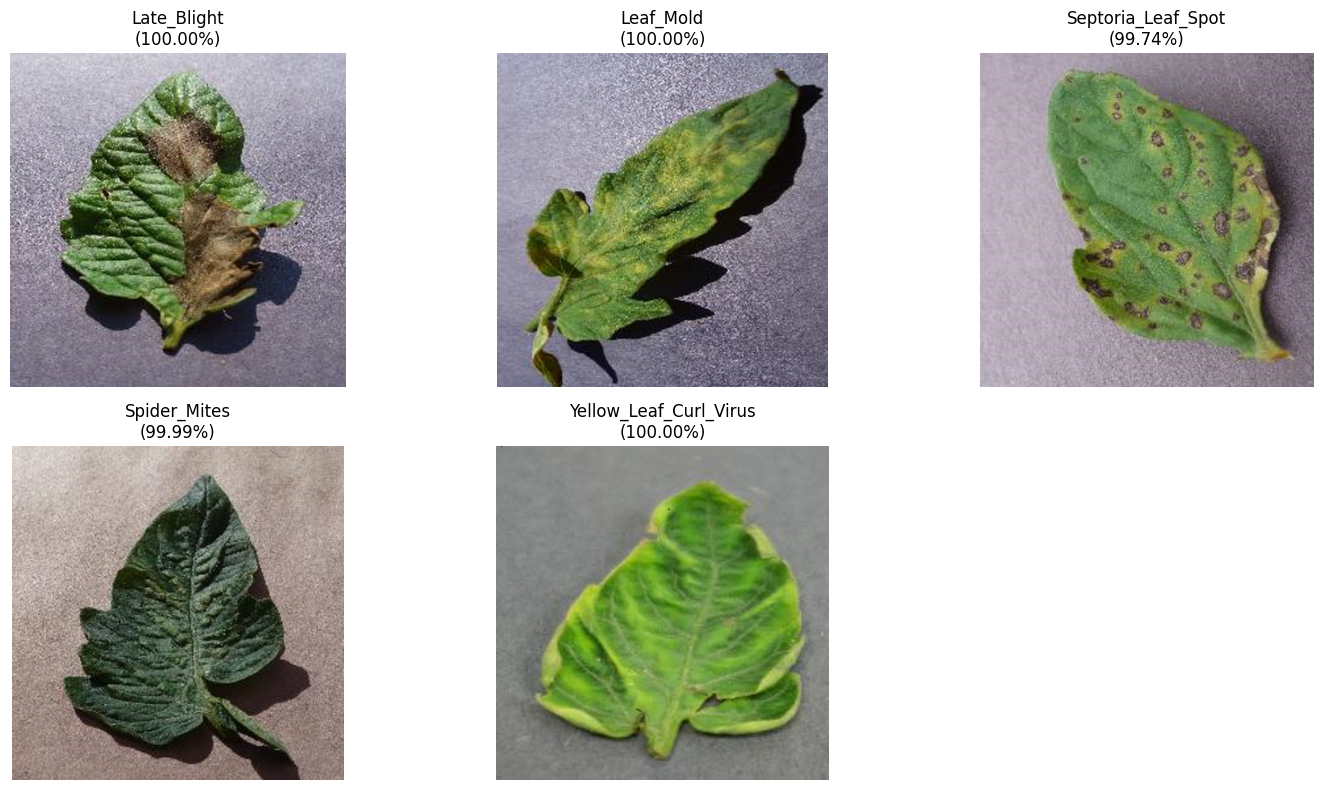

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("/content/TinyLeafNet-IoT_Custom.h5")

# List of image paths
image_paths = [
    "/content/tomato_1.png",
    "/content/tomato_2.png",
    "/content/tomato_3.png",
    "/content/tomato_4.png",
    "/content/tomato_5.png"
]

# Your class labels (replace with your actual class names)
class_names = ['Late_Blight', 'Leaf_Mold', 'Septoria_Leaf_Spot', 'Spider_Mites',
 'Yellow_Leaf_Curl_Virus']  # example

# Preprocess images
images = []
originals = []
for path in image_paths:
    img = load_img(path, target_size=(96, 96))
    originals.append(load_img(path))  # for display in original resolution
    img_array = img_to_array(img) / 255.0
    images.append(img_array)

# Stack into NumPy array
images_np = np.array(images)

# Predict
predictions = model.predict(images_np)

# Display Result
cols = 3
rows = math.ceil(len(image_paths) / cols)

# Create figure
plt.figure(figsize=(5 * cols, 4 * rows))

for i in range(len(image_paths)):
    pred_idx = np.argmax(predictions[i])
    label = class_names[pred_idx]
    confidence = predictions[i][pred_idx]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(originals[i])
    plt.title(f"{label}\n({confidence*100:.2f}%)", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()